In [36]:
import numpy as np
import pandas as pd #just in case i guess idk
import matplotlib.pyplot as plt #for graphing?
import math #this is how to get pi
import iop_ext as iop #artem's code for the radius/error functions - irradiated ocean planets

In [37]:
#DEFINE CONSTANTS
Lsun = 3.846*(10**(26)) #luminosity of sun in watts
Msun = 1.9891*(10**(30)) #mass of sun in kg
Mearth = 5.97219*(10**(24)) #mass of earth in kg
Rearth = 6.371*(10**6) #radius of earth in m
au = 1.49598*(10**11) #astronomical unit (distance from earth to sun) in m
yr = 3600*24*365 #converting years to seconds
a0 = 0.5 #slope at which Lhe decreases over time
tsat = 100*1e6*yr #in sec (length of the saturation phase?)
G = 6.67*(10**(-11)) #universal gravitational constant
pi = math.pi #pi

#PLANET: TOI-836b
Lstar =  0.14035930205*Lsun #luminosity of host star
Mstar =  0.678*Msun #mass of host star
Teq = 871 #equillibrium temperature of planet in K
a = 0.04220*au #semimajor axis
x0 = 0.5 #initial WMF (we decided this one arbitrarily)(this is why the radius we compute might not match the one in the catalog)

Lsat = (10**(-3.5))*Lsun*(Mstar/Msun) #Lhe (high energy luminosity - Xrays and UV) during the saturation phase (Lhe remains constant)
CMFprime = 0.325 #planet reduced core mass fraction (cmf') - same as earth

In [38]:
#INITIALIZE VARIABLES (will be added to in the loop but this is where they start)
t = 1e6*yr #initial time - 1 million
M0 = 4.53*Mearth #initial mass of planet
Mp = M0 #planet mass

In [39]:
#DEFINE FUNCTIONS
def RpFunction(CMF, x, Teq, Mp): #function to find the radius of the planet in m
    radius = iop.radius_iop(CMF, x, Teq, Mp/Mearth) #computes the radius of a planet, using the IOP model from Aguichine 2021
    return radius*Rearth

def nFunction(Mp, Rp): #n = efficiency parameter (greek letter eta) (unitless) - how much high energy is converted into mass loss
    vesc = ((2*G*Mp)/(Rp))**(1/2) #escape velocity at the planet's surface
    n = 0.1*((vesc/15)**(-2))
    return n

def LheFunction(t): #Lhe = high energy luminosity of the host star
    if (t<tsat):
        return Lsat
    else:
        Lhe = Lsat*((t/tsat)**(-1-a0))
        return Lhe

def mFunction(Mp, Rp, t): #first time derivative of Mp (mass loss rate) in kg/s
    Lhe = LheFunction(t)
    n = nFunction(Mp, Rp)
    m = (n*(((pi)*(Rp**3)*(Lhe))/(4*(pi)*(a**2)*(G)*(Mp))))
    return m #this returns the mass loss rate in kilograms per second
#to get mass loss in earth masses per billion years, multiply result by 1e9*yr and divide by Mearth (see test code from meeting)

def xwmfFunction(Mp): #x = water mass fraction
    # original guess was x = (Mp-(M0*x0))/Mp but I fear that may be wrong
    x = (M0*x0-M0+Mp)/Mp
    #basically W0(initial amount of water) = M0*x0, Mlost = M0-Mf, Wf(final amount of water) = W0-Mlost, x = (Wf/Mf)
    return x

In [40]:
#TEST CODE FROM MEETING
x = xwmfFunction(Mp)
R0 = RpFunction(CMFprime, x, Teq, Mp)
# print(RpFunction(CMFprime, x, Teq, Mp)/Rearth) #radius IN EARTH RADII
# print(mFunction(Mp, R0, t)*(1e9*yr)/Mearth) #this gives mass loss in earth masses per billion years

In [41]:
#EVOLUTION

t_start = 1e6*yr
t_end = 5*1e9*yr #5 billion years
time_step_save = 5*1e6*yr #every million years - 1,000 values total

deltat = 1e6*yr #incrimenting by 1 million years

R0 = RpFunction(CMFprime, x, Teq, M0)
m = mFunction(M0, R0, t_start)

errorCode = iop.error_iop(CMFprime, x0, Teq, M0/Mearth)

timeArray = np.zeros(0) #empty array
massArray = np.zeros(0)
radiusArray = np.zeros(0)
xArray = np.zeros(0)

timeArray = np.append(timeArray, t_start) #append initial values
massArray = np.append(massArray, M0)
radiusArray = np.append(radiusArray, R0)
xArray = np.append(xArray, x0)


print("MAKE SURE THESE ARE DIFFERENT NUMBERS: " + str(t) + ", " + str(t_end)) #this is just a test !!!

while (t < t_end): #after it has evolved for 5 billion years
    t = t+deltat #incriments t
    Mp = Mp-(m*deltat) #incriments Mp
    x = xwmfFunction(Mp)
    Rp = RpFunction(CMFprime, x, Teq, Mp)
    errorCode = iop.error_iop(CMFprime, x, Teq, Mp/Mearth)
    m = mFunction(Mp, Rp, t)

    if (x < 0):
        print ("Stopping because WMF is below 0")
        break
    elif (Rp < 0):
        print ("Stopping because Radius is below 0")
        break
    elif (errorCode == 2):
        print ("Stopping because error code is 2")
        break
    elif (m < 0):
        print ("Stopping because mass loss rate is negative")
        break
    
    #store these values in arrays:
    if ((t%time_step_save) == 0): #every five million years (1000 times)
        timeArray = np.append(timeArray, t)
        massArray = np.append(massArray, Mp)
        radiusArray = np.append(radiusArray, Rp)
        xArray = np.append(xArray, x)

print ()

print("Initial Mass: " + str(M0) + ",  Initial Radius: " + str(R0) + ",  Initial WMF: " + str(x0)) # print all initial properties
print("Final Mass: " + str(Mp) + ",  Final Radius: " + str(Rp) + ",  Final WMF: " + str(x)) # print final properties
print()
print("Initial Mass, Radii in Earth units: " + str(M0/Mearth) + ", " + str(R0/Rearth))
print("Final Mass, Radii in Earth units: " + str(Mp/Mearth) + ", " + str(Rp/Rearth))

print()

print (len(timeArray)) # test & make sure things are being appended and working
print(timeArray[0])
print(massArray[500])
print(radiusArray[999])
print(xArray[750])

MAKE SURE THESE ARE DIFFERENT NUMBERS: 31536000000000.0, 1.5768e+17

Initial Mass: 2.70540207e+25,  Initial Radius: 15281181.396867836,  Initial WMF: 0.5
Final Mass: 2.70540198665322e+25,  Final Radius: 15281181.235045956,  Final WMF: 0.4999999845962299

Initial Mass, Radii in Earth units: 4.53, 2.3985530367081833
Final Mass, Radii in Earth units: 4.529999860441848, 2.398553011308422

1001
31536000000000.0
2.7054019902543593e+25
15281181.235054407
0.49999998484478714


Text(0.5, 1.0, 'Evolution of TOI-836b')

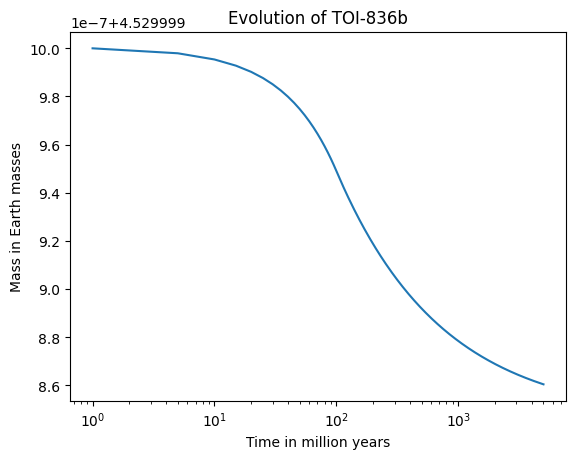

In [42]:
# plot results for mass

plt.plot(timeArray/(1e6*yr), massArray/Mearth)
plt.xscale("log")
plt.xlabel("Time in million years")
plt.ylabel("Mass in Earth masses")
plt.title("Evolution of TOI-836b")

Text(0.5, 1.0, 'Evolution of TOI-836b')

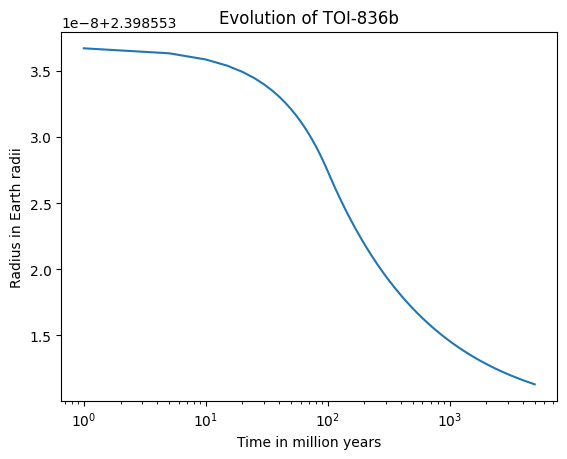

In [43]:
# plot results for radiuis

plt.plot(timeArray/(1e6*yr), radiusArray/Rearth)
plt.xscale("log")
plt.xlabel("Time in million years")
plt.ylabel("Radius in Earth radii")
plt.title("Evolution of TOI-836b")

Text(0.5, 1.0, 'Evolution of TOI-836b')

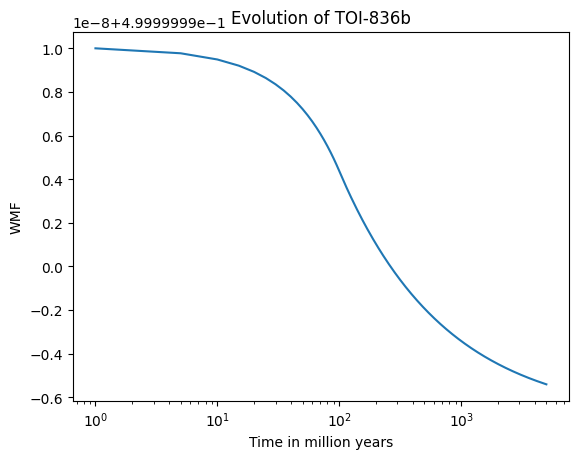

In [44]:
# plot results for WMF

plt.plot(timeArray/(1e6*yr), xArray)
plt.xscale("log")
plt.xlabel("Time in million years")
plt.ylabel("WMF")
plt.title("Evolution of TOI-836b")

# why does this look the same as the rest
# and why does the final WMF show up near -0.6 when x=.4999999845962299 in the end